In [1]:
import numpy as np
from IBP import *
import numpy as np
import matplotlib.pyplot as plt
import cython
import timeit
import math
import time
import numpy as np
from IBP import IBP
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
%load_ext cython

In [91]:
V1 = np.array([
    1, 0, 0, 0, 0, 0,
    1, 0, 0, 0, 0, 0,
    1, 0, 0, 0, 0, 0,
    1, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0
])
V2 = np.array([
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    1, 0, 0, 0, 0, 0,
    1, 1, 1, 0, 0, 0
])
V3 = np.array([
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 1, 1,
    0, 0, 0, 0, 1, 1
])
V4 = np.array([
    0, 0, 0, 0, 1, 1,
    0, 0, 0, 0, 0, 1,
    0, 0, 0, 0, 0, 1,
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0
])
V5 = np.array([
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    0, 1, 1, 1, 0, 0,
    0, 0, 1, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0
])
V = [V1, V2, V3, V4, V5]

N = 100
D1 = np.outer(np.random.binomial(1, 0.5, N), V1)
D2 = np.outer(np.random.binomial(1, 0.5, N), V2)
D3 = np.outer(np.random.binomial(1, 0.5, N), V3)
D4 = np.outer(np.random.binomial(1, 0.5, N), V4)
D5 = np.outer(np.random.binomial(1, 0.5, N), V5)
X = D1 + D2 + D3 + D4 + D5
X = X[np.sum(X, axis = 1) > 0] * 1.0
X += np.random.normal(0, 0.1, X.shape)
print(X.shape)

(99, 36)


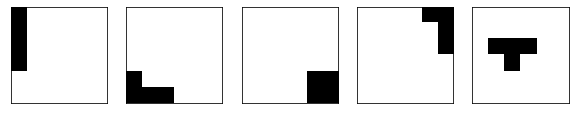

In [121]:
fig, ax = plt.subplots(1,5,figsize = (10,2))
for i in range(5):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow((1-V[i]).reshape(6,6), 'gray')
plt.savefig('paper/tetris.png', bbox_inches='tight')

In [97]:
ibp = IBP(X, alpha = (1,1,1), sigma_X = (1,1,1), sigma_A = (1,1,1))
hist = ibp.MCMC(1000)
#print("K", history["K"])
#print("alpha", history["alpha"])
#print("sigma_X", history["sigma_X"])
#print("sigma_A", history["sigma_A"])

Current K = 5: 100%|██████████| 1000/1000 [02:40<00:00,  4.92it/s]


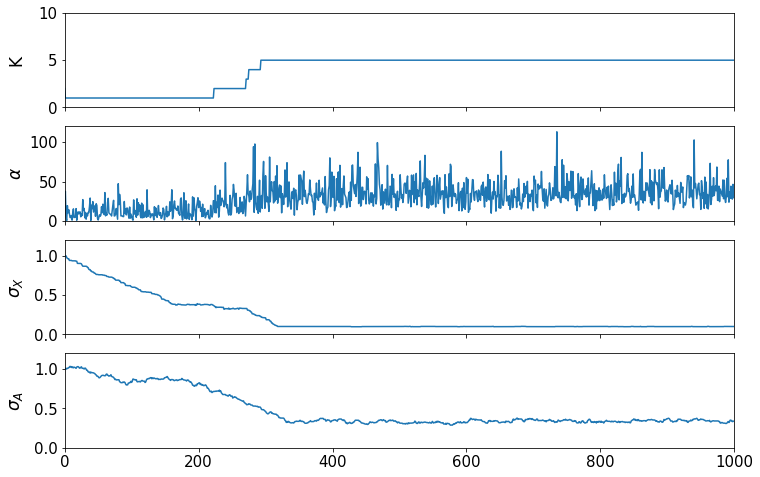

In [123]:
fig, ax = plt.subplots(4,1,sharex = True, figsize = (12,8))
ax[0].plot(hist['K'])
ax[0].set_ylabel('K', fontsize = 17)
ax[0].set_ylim(0,10)
ax[1].plot(hist['alpha'])
ax[1].set_ylabel('$\\alpha$',fontsize = 17)
ax[1].set_ylim(0,120)
ax[2].plot(hist['sigma_X'])
ax[2].set_ylabel('$\\sigma_X$',fontsize = 17)
ax[2].set_ylim(0,1.2)
ax[3].plot(hist['sigma_A'])
ax[3].set_ylabel('$\\sigma_A$',fontsize = 17)
ax[3].set_ylim(0,1.2)
plt.xlim(0,1000)
for i in range(4):
    ax[i].tick_params(labelsize=15)
fig.align_ylabels(ax)
plt.savefig('paper/gibbsresultblock.png', bbox_inches='tight')

In [99]:
def feature_map(feature, X_prior, Z, shape, order, truncate = None):
    feature = feature[order, :]
    Z = Z[:, order]
    if truncate is not None:
        feature = feature[:truncate, :]
        Z = Z[:, :truncate]
    X_post = Z @ feature
    f = plt.figure(figsize = (18,12))
    plt.axis('off')
    positive = np.tile(np.array([[[0.29803923, 0.6431373, 0.24705882]]]), reps = (*shape, 1))
    negative = np.tile(np.array([[[0.9, 0.9, 0.9]]]), reps = (*shape, 1))
    grid = gridspec.GridSpec(nrows = (X_prior.shape[0] + 1), ncols = (feature.shape[0] + 2), figure = f)
    for idf in range(feature.shape[0]):
        sp = f.add_subplot(grid[0, idf + 1])
        sp.set_xticks([])
        sp.set_yticks([])
        sp.imshow(feature[idf].reshape(shape), cmap = 'gray')
    for idx in range(X_prior.shape[0]):
        sp = f.add_subplot(grid[idx + 1, 0])
        sp.set_xticks([])
        sp.set_yticks([])
        sp.imshow(X_prior[idx].reshape(shape), cmap = 'gray')
        sp = f.add_subplot(grid[idx + 1, -1])
        sp.set_xticks([])
        sp.set_yticks([])
        sp.imshow(X_post[idx].reshape(shape), cmap = 'gray')
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            back = Z[i,j] * positive + (1 - Z[i,j]) * negative
            sp = f.add_subplot(grid[i + 1, j + 1])
            sp.set_xticks([])
            sp.set_yticks([])
            sp.axis('off')
            sp.imshow(back)

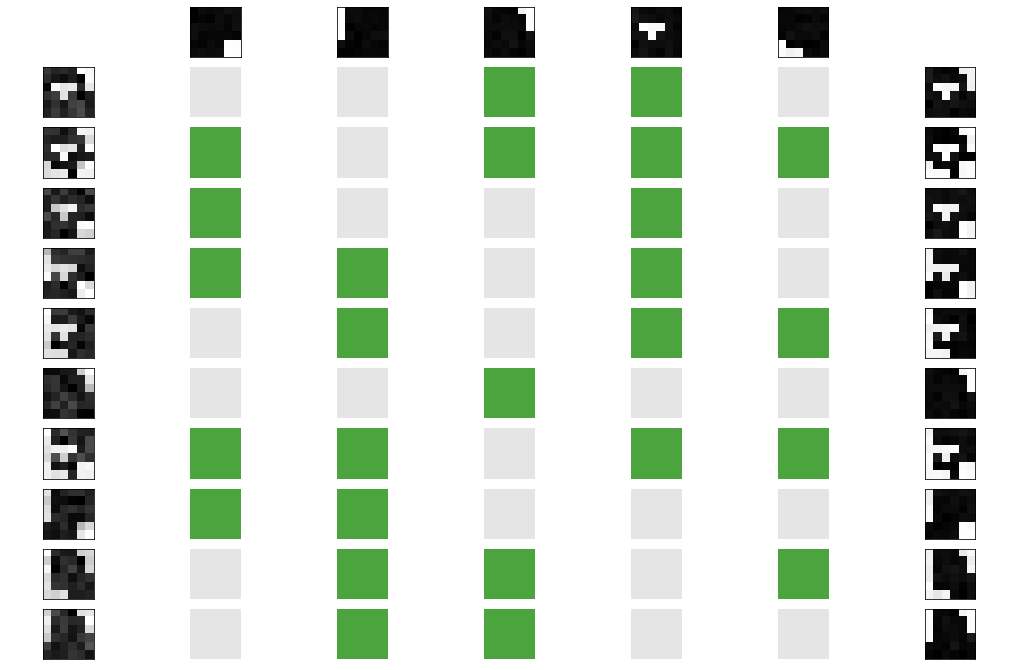

In [100]:
A = ibp.postMean()
Z = hist['Z'][-1]
idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
order = np.argsort(np.sum(Z, axis = 0))[::-1]
feature_map(A, X[idx], Z[idx], (6, 6), order = order)


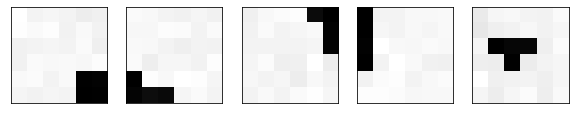

In [120]:
fig, ax = plt.subplots(1,5,figsize = (10,2))
for i in range(5):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow((1-A[i]).reshape(6,6), 'gray')
plt.savefig('paper/tetrisfeature.png', bbox_inches='tight')

In [104]:
hist['sigma_X'][-1]

0.09956969875350927

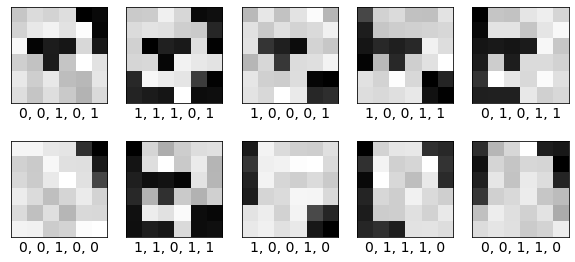

In [122]:
fig, ax = plt.subplots(2,5,figsize = (10,4.5))
def to_str(a):
    s = ''
    for i in range(a.shape[0]):
        if i != 0:
            s += ', '
        s += str(int(a[i]))
    return s
for i in range(10):
    ax[i // 5, i % 5].set_xticks([])
    ax[i // 5, i % 5].set_yticks([])
    ax[i // 5, i % 5].imshow((1-X[i]).reshape(6,6), 'gray')
    ax[i // 5, i % 5].set_xlabel(to_str(Z[i]), fontsize = 14)
plt.savefig('paper/tetrisdetection.png', bbox_inches='tight')

IndexError: index 5 is out of bounds for axis 0 with size 5